In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from CompoTree import ComponentTree, Radicals, TSVariants, CharLexicon
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "HanaMinA" 

In [4]:
kv = KeyedVectors.load("../data/fasttext-zh-sw/fasttext-zh-sw.kv")
kv.init_sims()

In [5]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()
lexicon = CharLexicon.load()


In [6]:
import umap
reducer = umap.UMAP()

In [7]:
umap_proj = reducer.fit_transform(kv.vectors)

In [8]:
umap_proj.shape

(12474, 2)

In [9]:
proj_data = pd.DataFrame(dict(
            char=list(kv.vocab.keys()), 
            radical=[radicals.query(x)[0] for x in kv.vocab.keys()],
            is_simp=[tsvars.is_simplified(x) for x in kv.vocab.keys()],
            umap1=umap_proj[:,0], umap2=umap_proj[:,1]))

In [10]:
import seaborn as sns

In [11]:
proj_data.assign(rad=proj_data.radical==radicals.query("你")[0])

,char,radical,is_simp,umap1,umap2,rad
0,的,白,False,9.230518,2.714842,False
1,年,干,False,9.453977,2.741956,False
2,月,月,False,9.453215,2.779282,False
3,日,日,False,9.466350,2.707849,False
4,在,土,False,9.281351,2.721444,False
...,...,...,...,...,...,...
12469,媦,女,False,1.718601,1.107293,False
12470,罉,缶,False,0.361767,1.561661,False
12471,銉,金,False,-0.520267,-1.198086,False
12472,螾,虫,False,0.314104,0.521510,False


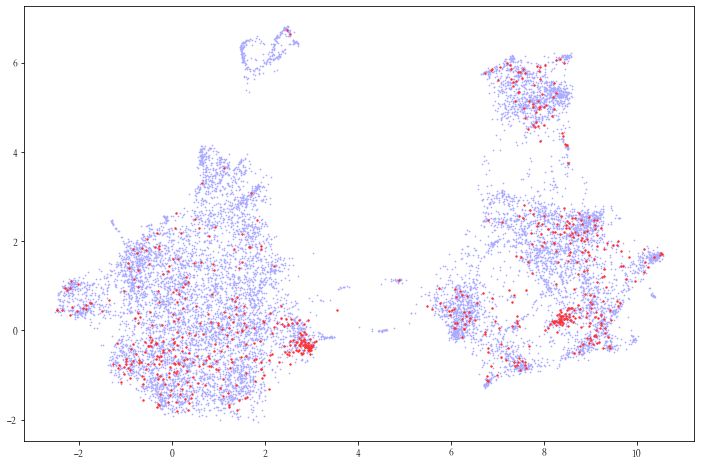

In [48]:
plt.figure(figsize=(12,8))
rad_mask = proj_data.radical==radicals.query("河")[0]
simp_mask = proj_data.is_simp
row_mask = rad_mask
plt.scatter(proj_data.loc[~row_mask, "umap1"], proj_data.loc[~row_mask, "umap2"], color="#AAAAFF", s=0.5)
plt.scatter(proj_data.loc[row_mask, "umap1"], proj_data.loc[row_mask, "umap2"], color="#FF3333", s=2)

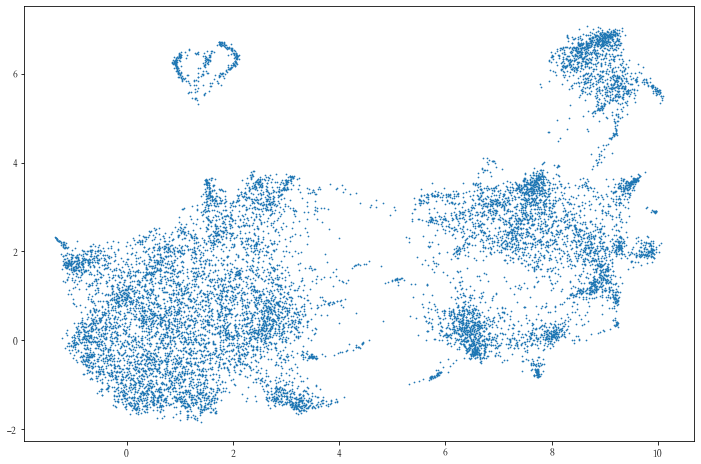

In [19]:
plt.figure(figsize=(12,8))
plt.scatter(umap_proj[:,0], umap_proj[:,1], s=0.5)

In [6]:
ctree.query("灘", use_flag="first")[0].children

[['氵'], [<⿰:[<⿱:廿⿻口夫>]['隹'](GTKV)>]]

In [8]:
tsvars.convert("螢")

['萤']

In [8]:
from collections import defaultdict
chars_set = set()
compo_set = set()
decompo_set = set()
compo_items = set()
for word in lexicon:  
    if word not in kv.vocab:
        continue
        
    try:
        ortho_x = ctree.query(word, 
                          max_depth=1, 
                          use_flag="shortest")[0]
    except:
        print(word)
        continue
            
    if isinstance(ortho_x, str):
        compos = [ortho_x]
    else:
        compos = [str(x) for x in 
                  ortho_x.components(use_flag="shortest")]
        
    compo_seq = tuple(sorted(compos))     
    if compo_seq not in compo_items and len(compos) == 2:
        compo_items.add(compo_seq)
    else:        
        continue
    
    chars_set.add(word)    
    if tsvars.is_simplified(word):
        compos = [x+"_s" for x in compos]
    else:
        compos = [x+"_t" for x in compos]
       
    compo_set |= set(compos)
    decompo_set |= set((word, str(compo_x))
                       for compo_x in compos)    

In [9]:
len(chars_set), len(compo_set), len(decompo_set)

(6156, 2497, 12292)

In [10]:
sorted(list(decompo_set), key=lambda x: x[0])[:20]

[('丁', '亅_t'),
 ('丁', '一_t'),
 ('七', '乚_t'),
 ('七', '㇀_t'),
 ('万', '一_s'),
 ('万', '⿰丿𠃌_s'),
 ('三', '二_t'),
 ('三', '一_t'),
 ('上', '⺊_t'),
 ('上', '一_t'),
 ('下', '卜_t'),
 ('下', '一_t'),
 ('丕', '一_t'),
 ('丕', '不_t'),
 ('丙', '一_t'),
 ('丙', '内_t'),
 ('丛', '一_s'),
 ('丛', '从_s'),
 ('丝', '⿰②②_s'),
 ('丝', '一_s')]

## Component Matrix

In [11]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [12]:
char_enc = LabelEncoder()
compo_enc = LabelEncoder()
char_enc.fit(list(chars_set))
compo_enc.fit(list(compo_set))

LabelEncoder()

In [13]:
n_char = len(char_enc.classes_)
n_compo = len(compo_enc.classes_)

In [14]:
decompo_matrix = np.zeros((n_char, n_compo), dtype=np.int32)
decompo_matrix.shape

(6156, 2497)

In [15]:
for item_x in decompo_set:
    char_idx = char_enc.transform([item_x[0]])[0]
    compo_idx = compo_enc.transform([item_x[1]])[0]
    decompo_matrix[char_idx, compo_idx] = 1

In [16]:
aa = LabelEncoder()
aa.fit(["a", "b", "c"])

LabelEncoder()

In [17]:
sel_compo_idx = decompo_matrix.sum(axis=0)>1
sel_compo_enc = LabelEncoder()
sel_compo_enc.fit(compo_enc.classes_[sel_compo_idx])
decompo_matrix_reduced = decompo_matrix[:, sel_compo_idx]
print(decompo_matrix_reduced.shape)
la.matrix_rank(decompo_matrix_reduced)

(6156, 1407)


1407

In [18]:
## Character semantic vector
word_kv_idxs = []
for word in char_enc.classes_:
    word_kv_idxs.append(kv.vocab[word].index)
char_ft = kv.vectors_norm[word_kv_idxs, :]
char_ft.shape

(6156, 300)

## Component semantic matrix
$$
C_{k\times d}: \textrm{Component semantic matrix, k components $\times$ d vector size }\\
Z_{n\times d}: \textrm{Character semantic matrix, n characters $\times$ d vector size }\\
D_{n\times k}: \textrm{Decomposition matrix, n characters $\times$ k components}\\
Z = D\cdot C\\
C = (D^\top D)^{-1}D^\top Z
$$

In [19]:
import numpy as np
import numpy.linalg as la

D = decompo_matrix_reduced
Z = char_ft
print("D, Z: ", D.shape, Z.shape)
compo_ft = la.inv(D.T.dot(D)).dot(D.T).dot(Z)

D, Z:  (6156, 1407) (6156, 300)


In [20]:
Zhat = D.dot(compo_ft)
R = Z.dot(Zhat.T)

In [21]:
def query_component(compo, is_trad=True):
    if is_trad is not None:
        compo = compo + ("_t" if is_trad else "_s")
    compo_vec = compo_ft[sel_compo_enc.transform([compo])[0]]
    return compo_vec

In [22]:
list(zip(kv.similar_by_vector(query_component("又", is_trad=True)),
    kv.similar_by_vector(query_component("又", is_trad=False))))

[(('而', 0.9840849041938782), ('却', 0.9875600934028625)),
 (('即', 0.9838416576385498), ('虽', 0.9869415760040283)),
 (('亦', 0.9832538366317749), ('则', 0.9865677356719971)),
 (('取', 0.9828312397003174), ('对', 0.9858291149139404)),
 (('如', 0.9821022748947144), ('说', 0.9856451749801636)),
 (('也', 0.9820734858512878), ('当', 0.9855595827102661)),
 (('之', 0.9817055463790894), ('与', 0.9846853017807007)),
 (('以', 0.9816076159477234), ('贤', 0.9843353629112244)),
 (('便', 0.981594979763031), ('还', 0.9842792749404907)),
 (('和', 0.9814806580543518), ('许', 0.9842578768730164))]

In [23]:
{v: k for k, v in radicals.ts_radicals.items()}["金"]

'钅'

In [24]:
tsvars.is_traditional("妻")

False

In [25]:
list(zip(kv.similar_by_vector(query_component("女", is_trad=True)),
    kv.similar_by_vector(query_component("女", is_trad=False))))

[(('妹', 0.9858518838882446), ('婶', 0.9854856133460999)),
 (('媚', 0.9857202768325806), ('嬷', 0.9837477803230286)),
 (('妻', 0.9856017827987671), ('敫', 0.9828739166259766)),
 (('姊', 0.9844710826873779), ('嫫', 0.9827786087989807)),
 (('逅', 0.9835814833641052), ('鐏', 0.9814938306808472)),
 (('嫂', 0.9832499623298645), ('姘', 0.9814498424530029)),
 (('婷', 0.9830593466758728), ('祃', 0.981367826461792)),
 (('綺', 0.9828788638114929), ('齹', 0.9809126257896423)),
 (('竟', 0.9828314185142517), ('婵', 0.9808992147445679)),
 (('玔', 0.9827866554260254), ('娆', 0.9808309078216553))]

In [26]:
list(zip(kv.similar_by_vector(query_component("金", is_trad=True)),
    kv.similar_by_vector(query_component("钅", is_trad=False))))

[(('鉆', 0.9834352135658264), ('熂', 0.9849629998207092)),
 (('搆', 0.9824538826942444), ('钣', 0.9849522709846497)),
 (('竉', 0.9824486374855042), ('毂', 0.9833048582077026)),
 (('鑄', 0.9819265007972717), ('铅', 0.9829593300819397)),
 (('鋃', 0.981760561466217), ('灮', 0.982614278793335)),
 (('袗', 0.9815495014190674), ('裎', 0.9825872182846069)),
 (('犠', 0.9815448522567749), ('铤', 0.9823060035705566)),
 (('緃', 0.9814175367355347), ('诽', 0.9819009900093079)),
 (('拑', 0.9813220500946045), ('鐏', 0.9815917611122131)),
 (('牐', 0.9808732271194458), ('拧', 0.9815613031387329))]

In [27]:
list(zip(kv.similar_by_vector(query_component("金", is_trad=True)),
    kv.similar_by_vector(query_component("钅", is_trad=False))))

[(('鉆', 0.9834352135658264), ('熂', 0.9849629998207092)),
 (('搆', 0.9824538826942444), ('钣', 0.9849522709846497)),
 (('竉', 0.9824486374855042), ('毂', 0.9833048582077026)),
 (('鑄', 0.9819265007972717), ('铅', 0.9829593300819397)),
 (('鋃', 0.981760561466217), ('灮', 0.982614278793335)),
 (('袗', 0.9815495014190674), ('裎', 0.9825872182846069)),
 (('犠', 0.9815448522567749), ('铤', 0.9823060035705566)),
 (('緃', 0.9814175367355347), ('诽', 0.9819009900093079)),
 (('拑', 0.9813220500946045), ('鐏', 0.9815917611122131)),
 (('牐', 0.9808732271194458), ('拧', 0.9815613031387329))]

In [28]:
simp_radicals = [x+"_s" for x in radicals.ts_radicals.keys()]
trad_radicals = [x+"_t" for x in radicals.ts_radicals.values()]
targets = [("又_s", "又_t"), ("言_s", "言_t"), ("女_s", "女_t")]

rois = []
for s, t in targets:
    if s in sel_compo_enc.classes_ and \
       t in sel_compo_enc.classes_:
        rois += [s, t]
print("rois count: ", len(rois))
for srad, trad in zip(simp_radicals, trad_radicals):
    if srad in sel_compo_enc.classes_ and \
       trad in sel_compo_enc.classes_:
        rois += [srad, trad]
print("rois count: ", len(rois))

rois count:  6
rois count:  46


In [29]:
roi_vectors = np.zeros((len(rois), compo_ft.shape[1]), dtype=np.float)
for roi_idx, roi_x in enumerate(rois):
    roi_vectors[roi_idx] = query_component(roi_x, is_trad=None)

In [30]:
roi_vectors.shape

(46, 300)

In [31]:
from sklearn.decomposition import PCA
roi_pca = PCA(3)
roi_2d = roi_pca.fit_transform(roi_vectors)

In [32]:
from matplotlib import font_manager

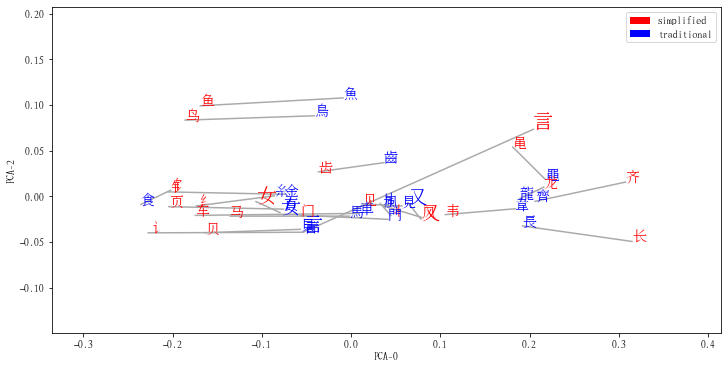

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "HanaMinA" 
plt.figure(figsize=(12,6))
idx_iter = iter(range(len(rois)))
dim_x = 0
dim_y = 2
for s_idx, t_idx in zip(*([idx_iter]*2)):
    s_compo = rois[s_idx].split("_")[0]
    t_compo = rois[t_idx].split("_")[0]
    
    text_args = dict(fontsize=14)
    if (rois[s_idx], rois[t_idx]) in targets:
        text_args["fontsize"]=20
    
    plt.text(roi_2d[s_idx, dim_x], roi_2d[s_idx, dim_y], 
             s_compo, color="red", **text_args)
    plt.text(roi_2d[t_idx, dim_x], roi_2d[t_idx, dim_y], 
             t_compo, color="blue", **text_args)
    plt.plot(roi_2d[[s_idx, t_idx], dim_x], roi_2d[[s_idx, t_idx], dim_y], color='#AAAAAA')
coord_max = roi_2d.max(axis=0)+0.1
coord_min = roi_2d.min(axis=0)-0.1
plt.xlim(coord_min[dim_x], coord_max[dim_x])
plt.ylim(coord_min[dim_y], coord_max[dim_y])
plt.xlabel(f"PCA-{dim_x}")
plt.ylabel(f"PCA-{dim_y}")
from matplotlib.patches import Patch
h_legends = [Patch(facecolor="red", label="simplified"),
             Patch(facecolor="blue", label="traditional")]
plt.legend(handles=h_legends, loc="upper right")